In [147]:
pip install prophet

In [148]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [149]:
from prophet import Prophet

In [150]:
df = pd.read_csv('/content/Forecasting_Output.csv')

In [151]:
df

,InvoiceNo,StockCode,Quantity,InvoiceDate,CustomerID,Country,Product,Img,Type,UnitPrice
0,541431,23166,74215,2011-01-18,12346,United Kingdom,Nikon 2199 SLR Lenses AF-S NIKKOR 50mm f/1.8G ...,https://c1.neweggimages.com/ProductImageCompre...,Camera Lenses,202.03
1,537626,84969,6,2010-12-07,12347,Iceland,Apple iPhone 7 Plus 32GB Verizon Black MNR12LL/A,https://c1.neweggimages.com/ProductImageCompre...,Unlocked Mobiles,529.97
2,537626,22728,4,2010-12-07,12347,Iceland,1.2.4GHz wireless mouse optical mouse 2.50g Li...,https://c1.neweggimages.com/ProductImageCompre...,Gaming Mouse,17.83
3,537626,22727,4,2010-12-07,12347,Iceland,Portable Bluetooth Speaker Waterproof Music Sp...,https://c1.neweggimages.com/ProductImageCompre...,Portable Speakers,17.99
4,537626,22726,4,2010-12-07,12347,Iceland,Titanium micro FT001-B Blue Smart Bluetooth Sp...,https://c1.neweggimages.com/ProductImageCompre...,Portable Speakers,17.99
...,...,...,...,...,...,...,...,...,...,...
392252,570715,23376,48,2011-10-12,18287,United Kingdom,Samsung Galaxy A10s (SM-A107F/DS) 32GB + 32GB ...,https://c1.neweggimages.com/ProductImageCompre...,Unlocked Mobiles,140.99
392253,570715,23378,24,2011-10-12,18287,United Kingdom,"Samsung Galaxy A10s( A107F/DS) 6.2"" Display, 3...",https://c1.neweggimages.com/ProductImageCompre...,Unlocked Mobiles,140.99
392254,573167,21824,48,2011-10-28,18287,United Kingdom,"Acer Aspire 5 A515-43-R19L 15.6"" Notebook - 19...",https://c1.neweggimages.com/ProductImageCompre...,Laptops,439.00
392255,573167,21014,24,2011-10-28,18287,United Kingdom,Nikon D5500 24MP DSLR Digital Camera AF-P 18-5...,https://c1.neweggimages.com/ProductImageCompre...,DSLR Cameras,759.99


In [152]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
CustomerID     0
Country        0
Product        0
Img            0
Type           0
UnitPrice      0
dtype: int64

In [153]:
df.duplicated().sum()

1

In [154]:
df = df.drop_duplicates()

In [155]:
df.describe()

,InvoiceNo,Quantity,CustomerID,UnitPrice
count,392256.000000,392256.000000,392256.000000,392256.000000
mean,560598.468546,13.157683,15287.377580,795.775117
std,13084.696735,181.696767,1713.558351,1313.652466
min,536365.000000,1.000000,12346.000000,2.700000
25%,549239.750000,2.000000,13953.000000,39.990000
50%,561879.000000,6.000000,15150.000000,295.000000
75%,572063.000000,12.000000,16791.000000,899.990000
max,581587.000000,80995.000000,18287.000000,10595.980000


In [156]:
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df.describe()

,InvoiceNo,Quantity,CustomerID,UnitPrice
count,392256.000000,392256.000000,392256.000000,392256.000000
mean,560598.468546,13.157683,15287.377580,795.775117
std,13084.696735,181.696767,1713.558351,1313.652466
min,536365.000000,1.000000,12346.000000,2.700000
25%,549239.750000,2.000000,13953.000000,39.990000
50%,561879.000000,6.000000,15150.000000,295.000000
75%,572063.000000,12.000000,16791.000000,899.990000
max,581587.000000,80995.000000,18287.000000,10595.980000


In [157]:
len(set(df['StockCode']))

3653

In [158]:
df['Daily Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,CustomerID,Country,Product,Img,Type,UnitPrice,Daily Sales
0,541431,23166,74215,2011-01-18,12346,United Kingdom,Nikon 2199 SLR Lenses AF-S NIKKOR 50mm f/1.8G ...,https://c1.neweggimages.com/ProductImageCompre...,Camera Lenses,202.03,14993656.45
1,537626,84969,6,2010-12-07,12347,Iceland,Apple iPhone 7 Plus 32GB Verizon Black MNR12LL/A,https://c1.neweggimages.com/ProductImageCompre...,Unlocked Mobiles,529.97,3179.82
2,537626,22728,4,2010-12-07,12347,Iceland,1.2.4GHz wireless mouse optical mouse 2.50g Li...,https://c1.neweggimages.com/ProductImageCompre...,Gaming Mouse,17.83,71.32
3,537626,22727,4,2010-12-07,12347,Iceland,Portable Bluetooth Speaker Waterproof Music Sp...,https://c1.neweggimages.com/ProductImageCompre...,Portable Speakers,17.99,71.96
4,537626,22726,4,2010-12-07,12347,Iceland,Titanium micro FT001-B Blue Smart Bluetooth Sp...,https://c1.neweggimages.com/ProductImageCompre...,Portable Speakers,17.99,71.96


In [159]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392256 entries, 0 to 392256
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392256 non-null  int64         
 1   StockCode    392256 non-null  object        
 2   Quantity     392256 non-null  int64         
 3   InvoiceDate  392256 non-null  datetime64[ns]
 4   CustomerID   392256 non-null  int64         
 5   Country      392256 non-null  object        
 6   Product      392256 non-null  object        
 7   Img          392256 non-null  object        
 8   Type         392256 non-null  object        
 9   UnitPrice    392256 non-null  float64       
 10  Daily Sales  392256 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 35.9+ MB


In [161]:
df['InvoiceDate'] = df['InvoiceDate'].dt.date

In [162]:
df_Sale_by_date = df.groupby('InvoiceDate')['Daily Sales'].sum().reset_index()

In [163]:
df_Sale_by_date.reset_index(drop=True, inplace=True)

In [164]:
df_Sale_by_date

,InvoiceDate,Daily Sales
0,2010-12-01,31874920.27
1,2010-12-02,30287574.18
2,2010-12-03,11710773.55
3,2010-12-05,14469811.91
4,2010-12-06,14912645.03
...,...,...
300,2011-12-05,26267868.13
301,2011-12-06,20568300.39
302,2011-12-07,26875171.54
303,2011-12-08,18769634.09


In [166]:
df_Sale_by_date['InvoiceDate'] = pd.to_datetime(df_Sale_by_date['InvoiceDate'])

In [167]:
df_Sale_by_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceDate  305 non-null    datetime64[ns]
 1   Daily Sales  305 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.9 KB


In [168]:
# Set 'InvoiceDate' as the index of the DataFrame
df_Sale_by_date.set_index('InvoiceDate', inplace=True)

In [169]:
# Resample the DataFrame based on daily intervals and calculate the mean
daily_sales = df_Sale_by_date.resample('D').mean()

In [170]:
daily_sales

,Daily Sales
InvoiceDate,
2010-12-01,31874920.27
2010-12-02,30287574.18
2010-12-03,11710773.55
2010-12-04,NaN
2010-12-05,14469811.91
...,...
2011-12-05,26267868.13
2011-12-06,20568300.39
2011-12-07,26875171.54


In [171]:
prophet_df = daily_sales.reset_index().dropna()

In [172]:
prophet_df

,InvoiceDate,Daily Sales
0,2010-12-01,31874920.27
1,2010-12-02,30287574.18
2,2010-12-03,11710773.55
4,2010-12-05,14469811.91
5,2010-12-06,14912645.03
...,...,...
369,2011-12-05,26267868.13
370,2011-12-06,20568300.39
371,2011-12-07,26875171.54
372,2011-12-08,18769634.09


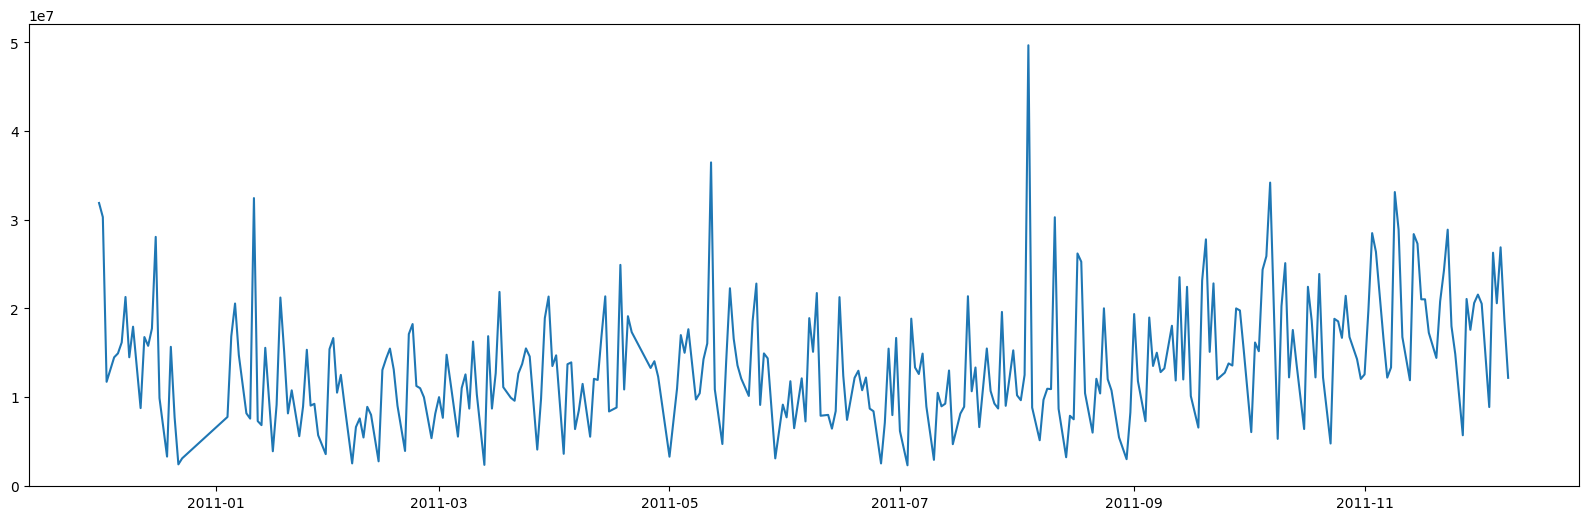

In [175]:
prophet_df.columns = ['ds', 'y']
fig = plt.figure(facecolor='w', figsize=(20, 6))
plt.plot(prophet_df.ds,prophet_df.y)

In [176]:
m = Prophet()
m.fit(prophet_df)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvpzyp3gy/fknq369g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvpzyp3gy/2hi9oi6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82274', 'data', 'file=/tmp/tmpvpzyp3gy/fknq369g.json', 'init=/tmp/tmpvpzyp3gy/2hi9oi6e.json', 'output', 'file=/tmp/tmpvpzyp3gy/prophet_modelra4sc1rk/prophet_model-20231214211227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
330,2012-01-04,2.180836e+07,1.455943e+07,2.880053e+07
331,2012-01-05,2.475649e+07,1.786456e+07,3.190862e+07
332,2012-01-06,1.881155e+07,1.220720e+07,2.605228e+07
333,2012-01-07,3.058044e+07,2.332170e+07,3.771000e+07
334,2012-01-08,1.419516e+07,6.699281e+06,2.114462e+07


In [177]:
forecast.to_csv('Forecast.csv')

In [178]:
period = (df['InvoiceDate'].max()-df['InvoiceDate'].min()).days

In [179]:
period

373

In [181]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-7:]

,ds,yhat,yhat_lower,yhat_upper
328,2012-01-02,2.055590e+07,1.377292e+07,2.753626e+07
329,2012-01-03,2.167818e+07,1.478010e+07,2.889346e+07
330,2012-01-04,2.180836e+07,1.455943e+07,2.880053e+07
331,2012-01-05,2.475649e+07,1.786456e+07,3.190862e+07
332,2012-01-06,1.881155e+07,1.220720e+07,2.605228e+07
333,2012-01-07,3.058044e+07,2.332170e+07,3.771000e+07
334,2012-01-08,1.419516e+07,6.699281e+06,2.114462e+07


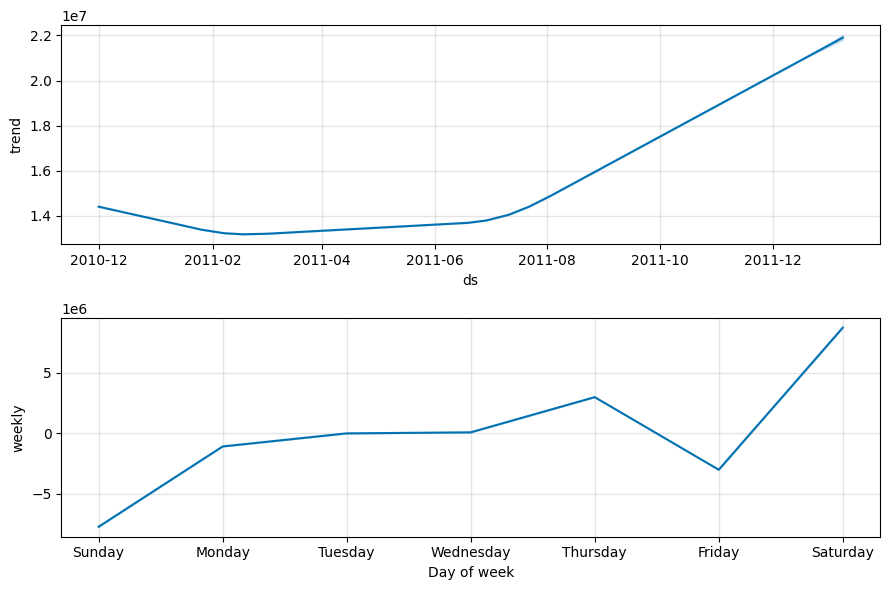

In [182]:
fig2 = m.plot_components(forecast)

In [184]:
pip install prophet

In [188]:
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(m, horizon='90 days')
df_p = performance_metrics(df_cv)
df_p.head(5)


INFO:prophet:Making 1 forecasts with cutoffs between 2011-09-10 00:00:00 and 2011-09-10 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpvpzyp3gy/vnqtlw1x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvpzyp3gy/gchrpmsz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54926', 'data', 'file=/tmp/tmpvpzyp3gy/vnqtlw1x.json', 'init=/tmp/tmpvpzyp3gy/gchrpmsz.json', 'output', 'file=/tmp/tmpvpzyp3gy/prophet_model1uuxh2uy/prophet_model-20231214212005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,8 days,3.856212e+13,6.209841e+06,4.239977e+06,0.219064,0.127083,0.283140,0.714286
1,9 days,3.639071e+13,6.032471e+06,4.143483e+06,0.194627,0.127083,0.236010,0.714286
2,10 days,6.543271e+13,8.089048e+06,6.130884e+06,0.263761,0.255772,0.330547,0.571429
3,11 days,5.148262e+13,7.175139e+06,4.927153e+06,0.217925,0.127083,0.269096,0.714286
4,12 days,5.648747e+13,7.515815e+06,5.582875e+06,0.238050,0.255772,0.296228,0.714286


ARIMA

In [191]:
daily_sales

,Daily Sales
InvoiceDate,
2010-12-01,31874920.27
2010-12-02,30287574.18
2010-12-03,11710773.55
2010-12-04,NaN
2010-12-05,14469811.91
...,...
2011-12-05,26267868.13
2011-12-06,20568300.39
2011-12-07,26875171.54


In [193]:
print(daily_sales['Daily Sales'].isnull().sum())

69


In [194]:
daily_sales['Daily Sales'].fillna(method='ffill', inplace=True)  # Fill missing values with forward fill


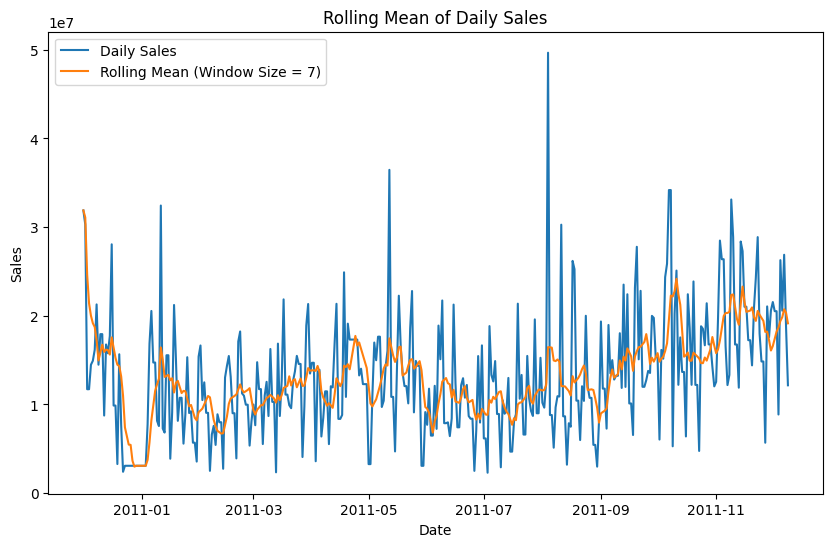

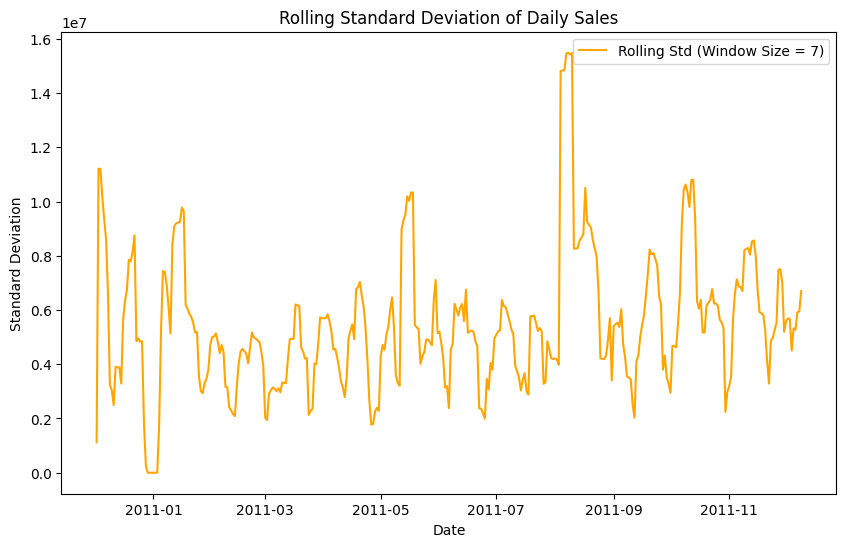

In [195]:
window_size = 7

# Rolling mean
daily_sales['Rolling Mean'] = daily_sales['Daily Sales'].rolling(window=window_size, min_periods=1).mean()

# Rolling standard deviation
daily_sales['Rolling Std'] = daily_sales['Daily Sales'].rolling(window=window_size, min_periods=1).std()

# Plotting the rolling mean and rolling standard deviation
plt.figure(figsize=(10, 6))

# Plotting the Daily Sales and Rolling Mean
plt.plot(daily_sales.index, daily_sales['Daily Sales'], label='Daily Sales')
plt.plot(daily_sales.index, daily_sales['Rolling Mean'], label='Rolling Mean (Window Size = 7)')
plt.title('Rolling Mean of Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Plotting the Rolling Standard Deviation
plt.figure(figsize=(10, 6))
plt.plot(daily_sales.index, daily_sales['Rolling Std'], color='orange', label='Rolling Std (Window Size = 7)')
plt.title('Rolling Standard Deviation of Daily Sales')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

In [197]:
# Find the maximum and minimum dates from the index
max_date = daily_sales.index.max()
min_date = daily_sales.index.min()

print("Maximum Date:", max_date)
print("Minimum Date:", min_date)


Maximum Date: 2011-12-09 00:00:00
Minimum Date: 2010-12-01 00:00:00


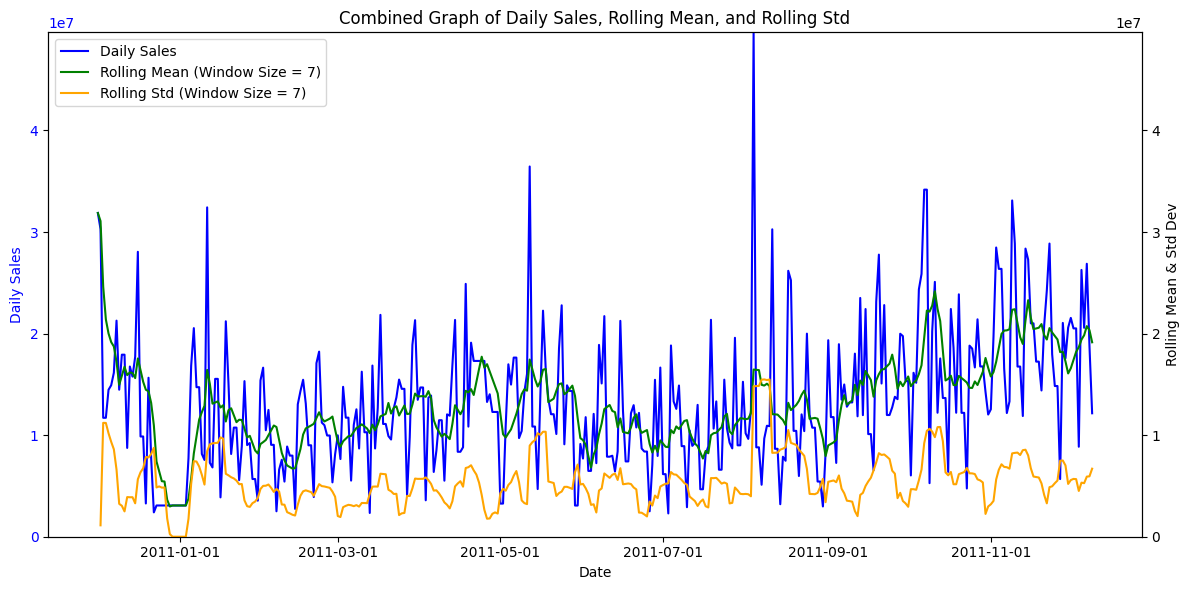

In [198]:
import matplotlib.pyplot as plt

# Assuming daily_sales DataFrame is prepared with 'Daily Sales', 'Rolling Mean', and 'Rolling Std' columns

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed

# Plotting Daily Sales on the primary y-axis
ax1.plot(daily_sales.index, daily_sales['Daily Sales'], label='Daily Sales', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for Rolling Mean and Rolling Std
ax2 = ax1.twinx()

# Plotting Rolling Mean and Rolling Std on the secondary y-axis
ax2.plot(daily_sales.index, daily_sales['Rolling Mean'], label='Rolling Mean (Window Size = 7)', color='green')
ax2.plot(daily_sales.index, daily_sales['Rolling Std'], label='Rolling Std (Window Size = 7)', color='orange')
ax2.set_ylabel('Rolling Mean & Std Dev', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set y-limits for the axes to ensure proper scale alignment
min_value = min(daily_sales['Daily Sales'].min(), daily_sales['Rolling Mean'].min(), daily_sales['Rolling Std'].min())
max_value = max(daily_sales['Daily Sales'].max(), daily_sales['Rolling Mean'].max(), daily_sales['Rolling Std'].max())
ax1.set_ylim(min_value, max_value)
ax2.set_ylim(min_value, max_value)

# Format x-axis ticks to show all dates
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))  # Format date display

# Adding legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Title for the combined graph
plt.title('Combined Graph of Daily Sales, Rolling Mean, and Rolling Std')

plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


In [199]:
result = adfuller(daily_sales['Daily Sales'])

In [200]:
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.5057393081909636
p-value: 0.007840914089511918
Critical Values:
	1%: -3.448343869853195
	5%: -2.869469418606909
	10%: -2.570994248260623


 **pcf to determine MA order**

**pacf to determine AR order**

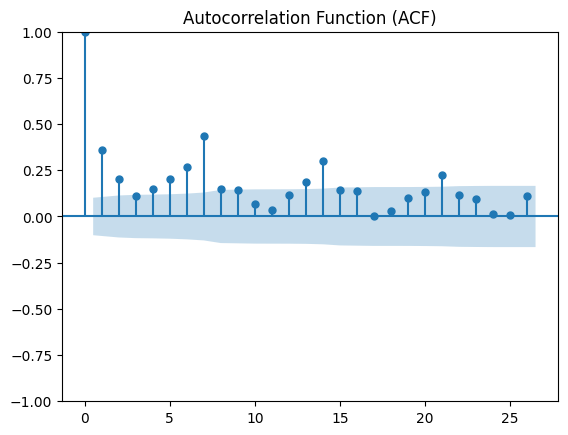

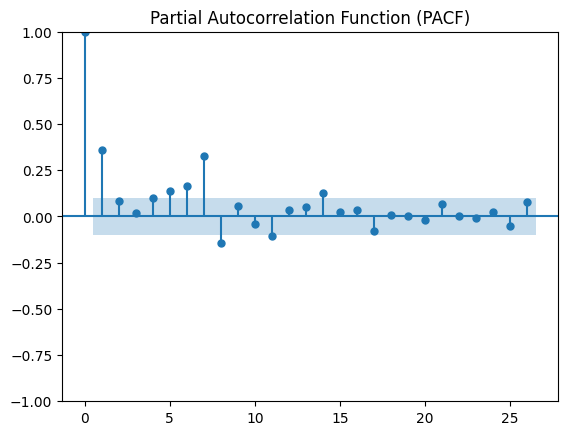

In [201]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'daily_sales' is your DataFrame with 'Daily Sales' column
# Plot ACF and PACF
plot_acf(daily_sales['Daily Sales'])  # Adjust the lags parameter as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(daily_sales['Daily Sales'])  # Adjust the lags parameter as needed
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


The ACF (Autocorrelation Function) peaks at lag 0 and has significant spikes at lags 7 and 13, and the PACF (Partial Autocorrelation Function) peaks at lag 0 and 7, we can use this information to determine possible values for 'p' and 'q' in our model.

ACF peaking at 0 is suggesting that the series has a high correlation with its immediate lag (lag 0), indicating the need for differencing (i.e., 'd' in the ARIMA model).

PACF peaking at 0 and 7 indicates that 'p' could be 0 or 7. Meanwhile, ACF peaking at 7 and 13 might suggest 'q' as 7 or 13.

with information, we can start by trying different combinations of 'p', 'd', and 'q' values in the ARIMA model to see which one fits best. we can try models with 'p' ranging from 0 to 7, 'd' as 1 (since differencing might be needed), and 'q' ranging from 0 to 13, based on the observed peaks in ACF and PACF plots.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:            Daily Sales   No. Observations:                  374
Model:                 ARIMA(7, 1, 7)   Log Likelihood               -6316.699
Date:                Thu, 14 Dec 2023   AIC                          12663.398
Time:                        21:25:52   BIC                          12722.221
Sample:                    12-01-2010   HQIC                         12686.756
                         - 12-09-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0616      0.150     -7.066      0.000      -1.356      -0.767
ar.L2         -0.6981      0.137     -5.114      0.000      -0.966      -0.431
ar.L3         -0.5824      0.091     -6.381      0.0

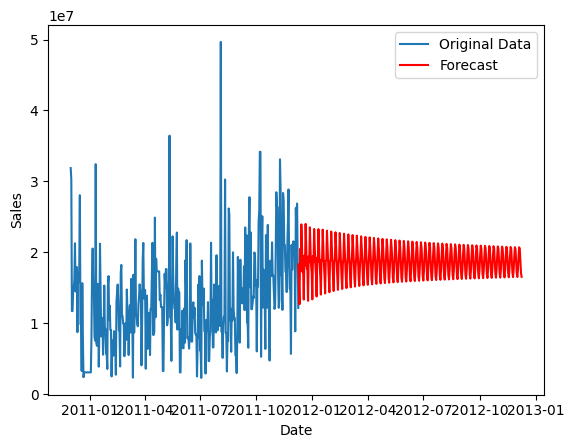

In [202]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model with identified p, d, q values
model = ARIMA(daily_sales['Daily Sales'], order=(7, 1, 7))  # Example using p=7, d=1, q=7 (as observed)
result = model.fit()

# Summary of the model
print(result.summary())

# Forecast using the ARIMA model
forecast = result.predict(start='2011-12-09', end='2012-12-09', dynamic=False)  # Replace with appropriate dates

# Plot the forecasted values
plt.plot(daily_sales.index, daily_sales['Daily Sales'], label='Original Data')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [204]:
# Reset the index to bring the 'Date' into a column
daily_sales.reset_index(inplace=True)

# Create a new DataFrame with 'Date' and 'Daily Sales' columns
ARIMA_df = daily_sales[['InvoiceDate', 'Daily Sales']].copy()

# Set 'Date' column as index again if needed
ARIMA_df.set_index('InvoiceDate', inplace=True)


In [205]:
ARIMA_df

,Daily Sales
InvoiceDate,
2010-12-01,31874920.27
2010-12-02,30287574.18
2010-12-03,11710773.55
2010-12-04,11710773.55
2010-12-05,14469811.91
...,...
2011-12-05,26267868.13
2011-12-06,20568300.39
2011-12-07,26875171.54


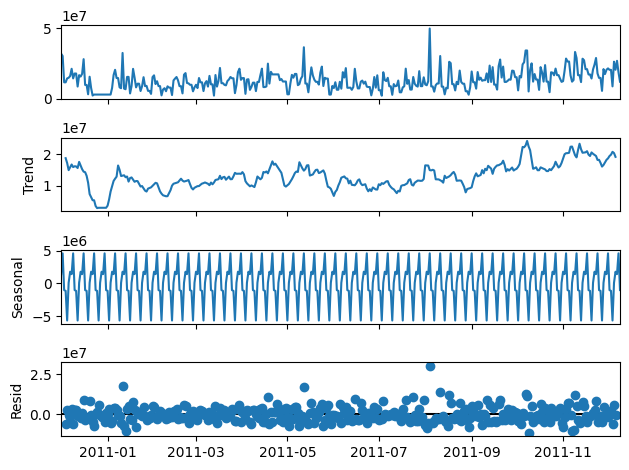

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


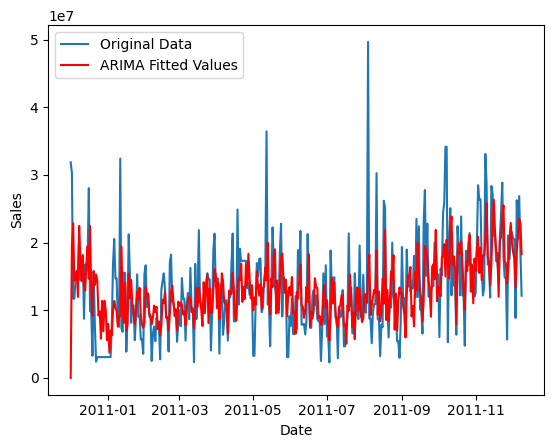

In [206]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assuming 'daily_sales' is your time series data with missing values

# # Fill missing values in 'daily_sales' using forward fill (you can choose another method as needed)
# daily_sales_filled = daily_sales.fillna(method='ffill')
# # Assuming 'df' is your DataFrame
# daily_sales_filled['Rolling Std'] = daily_sales_filled['Rolling Std'].fillna(method='ffill')  # Use another method if preferred


# Decompose the time series with filled missing values
decomposition = seasonal_decompose(ARIMA_df)  # Adjust period as per your data's seasonality

# Plot the decomposed components (trend, seasonal, residual)
decomposition.plot()
plt.show()

# Fit ARIMA model with filled data
model = ARIMA(ARIMA_df, order=(7, 1, 7))  # Example using p=7, d=1, q=7 (as observed)
results = model.fit()

# Plot the original data and fitted values from ARIMA
plt.plot(ARIMA_df.index, ARIMA_df, label='Original Data')
plt.plot(ARIMA_df.index, results.fittedvalues, color='red', label='ARIMA Fitted Values')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


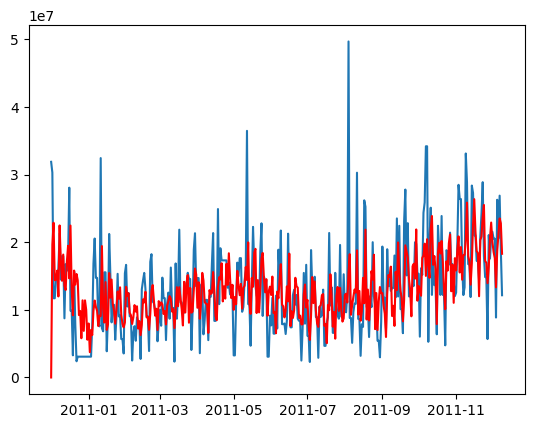

In [207]:
decomposition = seasonal_decompose(ARIMA_df)
model = ARIMA(ARIMA_df, order=(7,1,7))
results = model.fit()
plt.plot(ARIMA_df)
plt.plot(results.fittedvalues, color='red')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


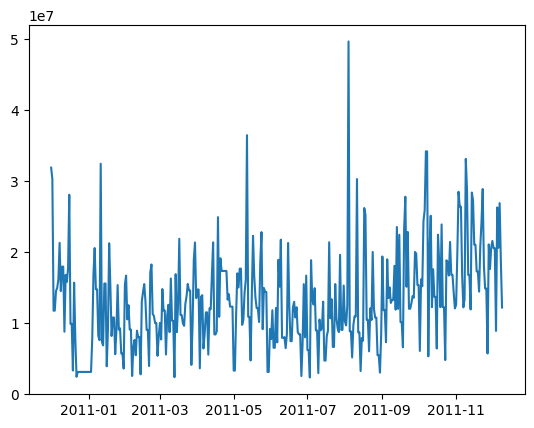

In [208]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ARIMA_df['Daily Sales'].iloc[0], index=ARIMA_df.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ARIMA_df)
plt.plot(predictions_ARIMA)

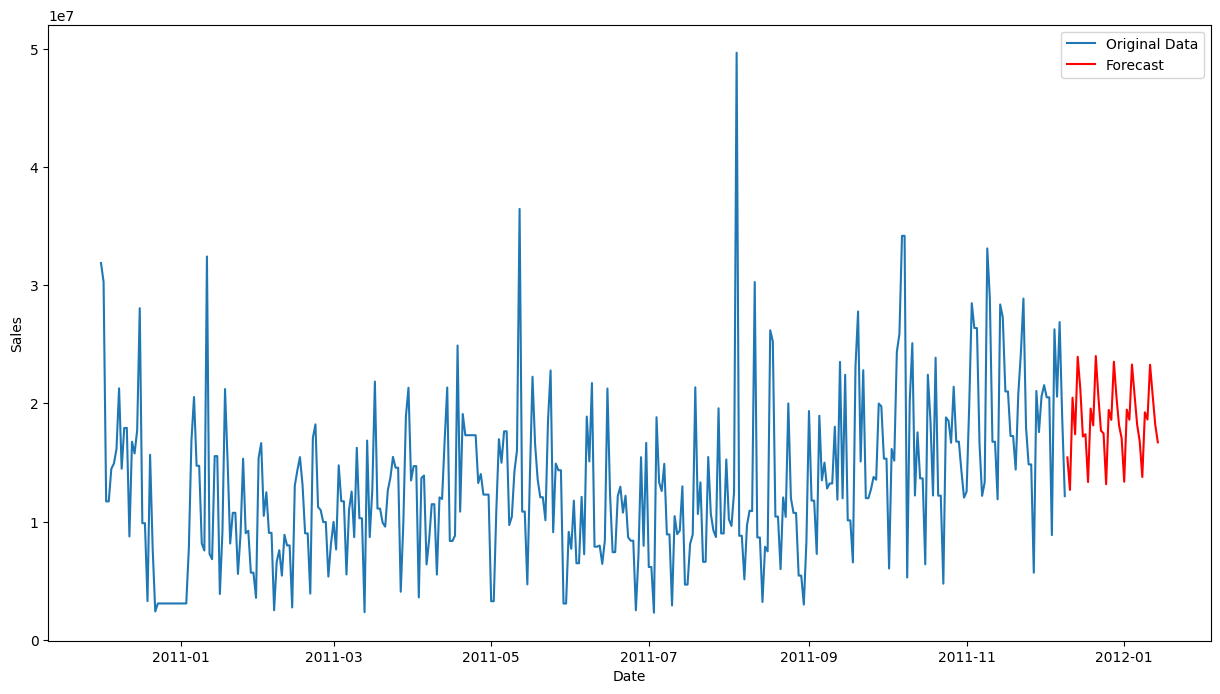

In [209]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assuming 'daily_sales' is your time series data with missing values and the ARIMA model is already fitted

# Forecast sales for the next 12 months (adjust steps as needed)
forecast_steps = 36
forecast = results.forecast(steps=forecast_steps)

# Create a range of future dates for the forecast
future_dates = pd.date_range(start=ARIMA_df.index[-1], periods=forecast_steps + 1, freq='D')[1:]

# Plot the original data and the forecasted values

plt.figure(figsize=(15, 8))


plt.plot(ARIMA_df.index, ARIMA_df, label='Original Data')
plt.plot(future_dates, forecast, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

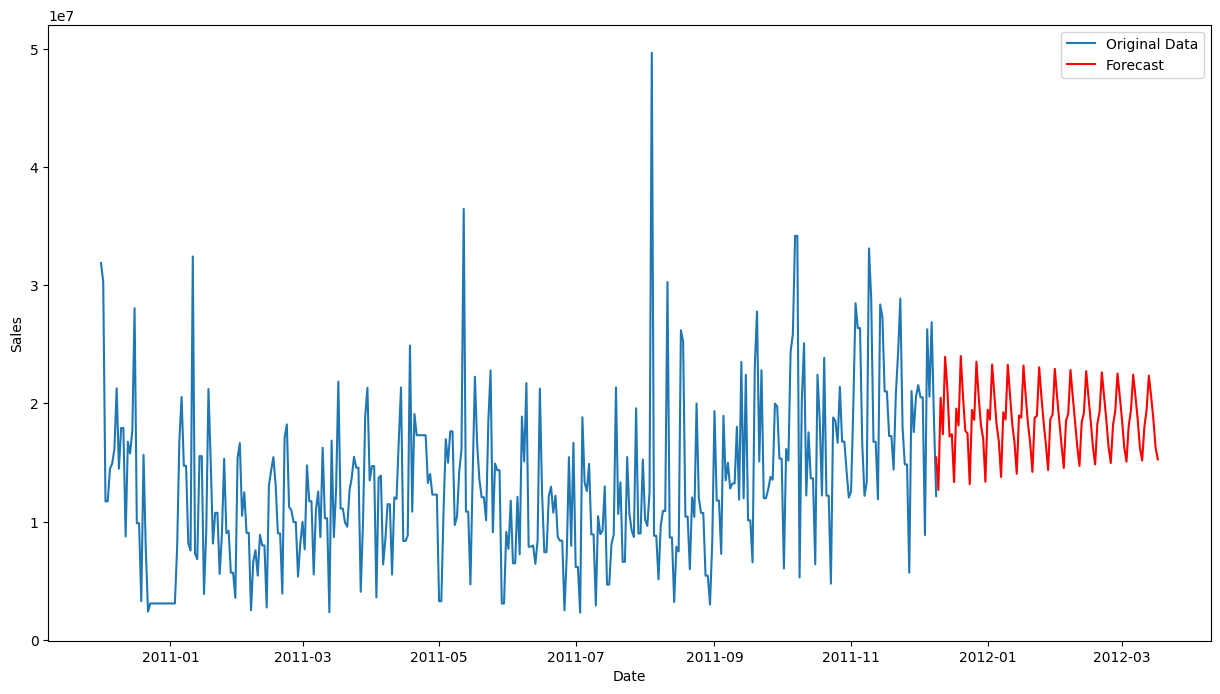

In [210]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assuming 'ARIMA_df' is your time series data with missing values and the ARIMA model is already fitted

# Forecast sales for the next 36 months (adjust steps as needed)
forecast_steps = 100
forecast = results.forecast(steps=forecast_steps)

# Create a range of future dates for the forecast (assuming 'ARIMA_df' is monthly data)
future_dates = pd.date_range(start=ARIMA_df.index[-1], periods=forecast_steps, freq='D')

# Set a larger plot size
plt.figure(figsize=(15, 8))

# Plot the original data and the forecasted values
plt.plot(ARIMA_df.index, ARIMA_df, label='Original Data')  # Replace 'Sales' with your column name
plt.plot(future_dates, forecast, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()



In [211]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Assuming 'ARIMA_df' is your time series data with missing values and the ARIMA model is already fitted

# Define the ARIMA model (adjust order as needed)
model = ARIMA(ARIMA_df['Daily Sales'], order=(7, 1, 7))  # Example order (p=7, d=1, q=7)

# Fit the ARIMA model on the entire dataset
results = model.fit()

# Forecast sales for future dates
forecast_steps = 12  # Example: forecast for the next 12 periods
future_dates = pd.date_range(start=ARIMA_df.index[-1], periods=forecast_steps + 1, freq='M')[1:]
forecast = results.forecast(steps=forecast_steps)

# Print or store the forecasted values for future dates
print(forecast)
# Or to store the forecasted values in a variable:
# forecast_values = forecast.values


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2011-12-10    1.543036e+07
2011-12-11    1.268008e+07
2011-12-12    2.048379e+07
2011-12-13    1.738754e+07
2011-12-14    2.394067e+07
2011-12-15    2.124354e+07
2011-12-16    1.719633e+07
2011-12-17    1.739279e+07
2011-12-18    1.334417e+07
2011-12-19    1.956193e+07
2011-12-20    1.813953e+07
2011-12-21    2.400545e+07
Freq: D, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [212]:
import pickle
with open('ARIMA AND PROPHET.pckl', 'wb') as fout:
    pickle.dump(m, fout)